In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [3]:
df_ETI = pd.read_excel('Spectral data.xlsx', sheet_name='elevatedTI')
df_ETIL = pd.read_excel('Spectral data.xlsx', sheet_name='elevatedTILD')
df_ETIL.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2
0,Inflow,center of the water tunnel,NaN
1,frequency,spectral density,wavenumber
2,0,0.009866,0
3,0.001526,0.01502,0.011692
4,0.003052,0.017734,0.023384


In [4]:
df_ETI = df_ETI.rename(columns={'Unnamed: 0': 'frequency', 'Unnamed: 1': 'spectral density'})
df_ETIL = df_ETIL.rename(columns={'Unnamed: 0': 'frequency', 'Unnamed: 1': 'spectral density'})

df_ETIL.head()

,frequency,spectral density,Unnamed: 2
0,Inflow,center of the water tunnel,NaN
1,frequency,spectral density,wavenumber
2,0,0.009866,0
3,0.001526,0.01502,0.011692
4,0.003052,0.017734,0.023384


In [5]:
df_ETI = df_ETI.drop([0, 1]).reset_index(drop=True)
df_ETIL = df_ETIL.drop([0, 1]).reset_index(drop=True)
df_ETIL.head()

,frequency,spectral density,Unnamed: 2
0,0,0.009866,0
1,0.001526,0.01502,0.011692
2,0.003052,0.017734,0.023384
3,0.004578,0.018372,0.035076
4,0.006104,0.017578,0.046768


In [6]:
# Convert columns to numeric type
df_ETI['frequency'] = pd.to_numeric(df_ETI['frequency'], errors='coerce')
df_ETI['spectral density'] = pd.to_numeric(df_ETI['spectral density'], errors='coerce')
# Remove any rows with NaN values
df_ETI = df_ETI.dropna()

# Convert columns to numeric type
df_ETIL['frequency'] = pd.to_numeric(df_ETIL['frequency'], errors='coerce')
df_ETIL['spectral density'] = pd.to_numeric(df_ETIL['spectral density'], errors='coerce')
# Remove any rows with NaN values
df_ETIL = df_ETIL.dropna()

df_ETIL.head()

,frequency,spectral density,Unnamed: 2
0,0.000000,0.009866,0
1,0.001526,0.015020,0.011692
2,0.003052,0.017734,0.023384
3,0.004578,0.018372,0.035076
4,0.006104,0.017578,0.046768


## Fit Option A: Kolmogorov −5/3 Law

Fit only the inertial subrange (typically mid-frequencies).

In [8]:
def kolmogorov(f, C):
    return C * f**(-5/3)

mask = (df_ETI['frequency'] > 2) & (df_ETI['frequency'] < 20)   # example inertial subrange
popt, pcov = curve_fit(kolmogorov, df_ETI['frequency'][mask], df_ETI['spectral density'][mask])

C_fit = popt[0]
print(f"Kolmogorov fit: C = {C_fit:.6f}")

Kolmogorov fit: C = 0.004430


## Fit Option B: Von Kármán Spectrum

Outputs:

* $\sigma ^2$
: turbulent variance → compute TI

* $L$: integral length scale

From this you can estimate dissipation rate:

$$\sigma = C_\epsilon \frac{u'^3}{L}$$



In [9]:
U = 0.82  # m/s

def von_karman(f, sigma2, L):
    k = 2*np.pi*f / U
    return (sigma2 * L / np.pi) * (1 + (k*L)**2 )**(-5/6)

popt, pcov = curve_fit(von_karman, df_ETI['frequency'], df_ETI['spectral density'], p0=[0.01, 0.1])
sigma2_fit, L_fit = popt
print(f"Von Kármán fit: σ² = {sigma2_fit:.6f}, L = {L_fit:.6f}")

Von Kármán fit: σ² = 0.115622, L = 0.108581


## Fit Option C: Empirical Spectrum

In [10]:
def empirical(f, A, p, B):
    return A * f**(-p) * np.exp(-B * f)

# Filter out zero frequency values
mask = df_ETI['frequency'] > 0
popt, pcov = curve_fit(empirical, df_ETI['frequency'][mask], df_ETI['spectral density'][mask], p0=[1, 1.6, 0.1])
A_fit, p_fit, B_fit = popt
print(f"Empirical fit: A = {A_fit:.6f}, p = {p_fit:.6f}, B = {B_fit:.6f}")

Empirical fit: A = 0.006091, p = -0.142228, B = 0.800351


c:\Users\Hosse\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Fit Option D: General Von Kármán Form

This fits the full von Kármán spectrum with low-k behavior:

$$E(k) = \alpha \epsilon^{2/3} L^{5/3} \frac{L^4 k^4}{(1 + L^2 k^2)^{17/6}}$$

In [7]:
U = 0.82  # m/s mean velocity

def von_karman_full(f, alpha, epsilon, L):
    """
    Full von Kármán spectrum with low-k behavior
    E(k) = alpha * epsilon^(2/3) * L^(5/3) * (L^4 * k^4) / (1 + L^2 * k^2)^(17/6)
    
    Parameters:
    f: frequency [Hz]
    alpha: dimensionless constant
    epsilon: turbulent dissipation rate [m²/s³]
    L: integral length scale [m]
    """
    k = 2 * np.pi * f / U  # wavenumber
    numerator = alpha * (epsilon**(2/3)) * (L**(5/3)) * (L**4) * (k**4)
    denominator = (1 + (L**2) * (k**2))**(17/6)
    return numerator / denominator

# Initial guesses: alpha~1, epsilon~0.001 m²/s³, L~0.1 m
p0 = [1.0, 0.001, 0.1]

# Fit the model
popt, pcov = curve_fit(von_karman_full, df_ETI['frequency'], df_ETI['spectral density'], 
                       p0=p0, maxfev=10000)

alpha_fit, epsilon_fit, L_fit = popt
perr = np.sqrt(np.diag(pcov))  # Standard errors

print(f"Von Kármán (full form) fit:")
print(f"  α = {alpha_fit:.6f} ± {perr[0]:.6f}")
print(f"  ε = {epsilon_fit:.6e} ± {perr[1]:.6e} m²/s³")
print(f"  L = {L_fit:.6f} ± {perr[2]:.6f} m")

# Calculate derived quantities
sigma_u = (epsilon_fit * L_fit)**(1/3)  # Turbulent velocity scale
TI = sigma_u / U * 100  # Turbulence intensity %

print(f"\nDerived quantities:")
print(f"  σ_u ≈ {sigma_u:.4f} m/s")
print(f"  TI ≈ {TI:.2f}%")

Von Kármán (full form) fit:
  α = 2.484806 ± 4489714.603985
  ε = 5.705267e-03 ± 1.549164e+04 m²/s³
  L = 0.558576 ± 0.011444 m

Derived quantities:
  σ_u ≈ 0.1472 m/s
  TI ≈ 17.95%


C:\Users\Hosse\AppData\Local\Temp\ipykernel_17852\561675576.py:15: RuntimeWarning: invalid value encountered in scalar power
  numerator = alpha * (epsilon**(2/3)) * (L**(5/3)) * (L**4) * (k**4)


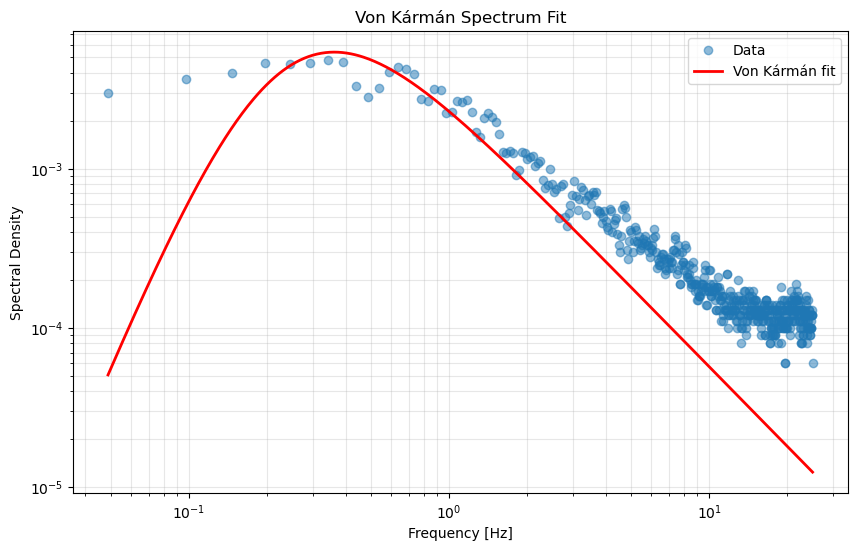

In [12]:
# Plot the fit
# Use only positive frequencies for fit line
f_min = df_ETI[df_ETI['frequency'] > 0]['frequency'].min()
f_max = df_ETI['frequency'].max()
f_fit = np.logspace(np.log10(f_min), np.log10(f_max), 500)
E_fit = von_karman_full(f_fit, alpha_fit, epsilon_fit, L_fit)

plt.figure(figsize=(10, 6))
plt.loglog(df_ETI['frequency'], df_ETI['spectral density'], 'o', alpha=0.5, label='Data')
plt.loglog(f_fit, E_fit, 'r-', linewidth=2, label='Von Kármán fit')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Spectral Density')
plt.title('Von Kármán Spectrum Fit')
plt.legend()
plt.grid(True, which='both', alpha=0.3)
plt.show()

## Extract Parameters for GenerateInflow.c

Convert fitted spectrum parameters to GenerateInflow.c input format

In [13]:
# From the fitted spectrum, extract parameters for GenerateInflow.c
# 
# GenerateInflow.c uses:
# E(k) = (D_coef * ustar^2 / Y_loc^(2/3)) * L^(5/3) * (L^4 * k^4) / (1 + L^2*k^2)^(17/6)
#
# Where:
#   fac1 = D_coef * ustar^2 / Y_loc^(2/3)  corresponds to  alpha * epsilon^(2/3)
#   L = L_coef * Y_loc

# User-defined parameters (must choose based on your problem):
Y_loc = 0.2794  # [m] Reference height - typically boundary layer height or measurement location
V_ref = 0.82  # [m/s] Reference velocity for non-dimensionalization  
L_ref = 0.2794   # [m] Reference length for non-dimensionalization

print("=== Input Parameters (user-defined) ===")
print(f"Y_loc = {Y_loc:.4f} m (reference height)")
print(f"V_ref = {V_ref:.4f} m/s (reference velocity)")
print(f"L_ref = {L_ref:.4f} m (reference length)")
print()

# From fitted spectrum:
alpha_spectrum = alpha_fit
epsilon_spectrum = epsilon_fit  # [m²/s³]
L_spectrum = L_fit              # [m]

print("=== Fitted Spectrum Parameters ===")
print(f"α = {alpha_spectrum:.6f}")
print(f"ε = {epsilon_spectrum:.6e} m²/s³")
print(f"L = {L_spectrum:.6f} m")
print()

# Calculate GenerateInflow.c parameters:
# From: alpha * epsilon^(2/3) = D_coef * ustar^2 / Y_loc^(2/3)
# We can choose: D_coef = alpha, then solve for ustar

D_coef = alpha_spectrum

# ustar^2 = epsilon^(2/3) * Y_loc^(2/3)
ustar_dimensional = (epsilon_spectrum * Y_loc)**(1/3)  # [m/s]

# Non-dimensionalize for GenerateInflow.c
ustar = ustar_dimensional / V_ref
ustar4mean = ustar  # Can be adjusted separately if needed

# Length scale coefficient
L_coef = L_spectrum / Y_loc

# Non-dimensionalize reference height
Y_loc_nondim = Y_loc / L_ref

print("=== GenerateInflow.c Parameters (dimensional) ===")
print(f"D_coef = {D_coef:.6f}")
print(f"ustar = {ustar_dimensional:.6f} m/s")
print(f"L_coef = {L_coef:.6f}")
print(f"Y_loc = {Y_loc:.6f} m")
print()

=== Input Parameters (user-defined) ===
Y_loc = 0.2794 m (reference height)
V_ref = 0.8200 m/s (reference velocity)
L_ref = 0.2794 m (reference length)

=== Fitted Spectrum Parameters ===
α = 2.885430
ε = 2.174186e-03 m²/s³
L = 1.530507 m

=== GenerateInflow.c Parameters (dimensional) ===
D_coef = 2.885430
ustar = 0.084692 m/s
L_coef = 5.477835
Y_loc = 0.279400 m



In [13]:
# Calculate goodness of fit
E_model = von_karman_full(df_ETI['frequency'], alpha_fit, epsilon_fit, L_fit)
residuals = df_ETI['spectral density'] - E_model
ss_res = np.sum(residuals**2)
ss_tot = np.sum((df_ETI['spectral density'] - np.mean(df_ETI['spectral density']))**2)
r_squared = 1 - (ss_res / ss_tot)

print(f"\nGoodness of fit:")
print(f"  R² = {r_squared:.6f}")


Goodness of fit:
  R² = 0.825629


In [9]:
U = 0.82  # m/s mean velocity

def von_karman_full(f, alpha, epsilon, L):
    """
    Full von Kármán spectrum with low-k behavior
    E(k) = alpha * epsilon^(2/3) * L^(5/3) * (L^4 * k^4) / (1 + L^2 * k^2)^(17/6)
    
    Parameters:
    f: frequency [Hz]
    alpha: dimensionless constant
    epsilon: turbulent dissipation rate [m²/s³]
    L: integral length scale [m]
    """
    k = 2 * np.pi * f / U  # wavenumber
    numerator = alpha * (epsilon**(2/3)) * (L**(5/3)) * (L**4) * (k**4)
    denominator = (1 + (L**2) * (k**2))**(17/6)
    return numerator / denominator

# Initial guesses: alpha~1, epsilon~0.001 m²/s³, L~0.1 m
p0 = [1.0, 0.001, 0.1]

# Fit the model
popt, pcov = curve_fit(von_karman_full, df_ETIL['frequency'], df_ETIL['spectral density'], 
                       p0=p0, maxfev=10000)

alpha_fit, epsilon_fit, L_fit = popt
perr = np.sqrt(np.diag(pcov))  # Standard errors

print(f"Von Kármán (full form) fit:")
print(f"  α = {alpha_fit:.6f} ± {perr[0]:.6f}")
print(f"  ε = {epsilon_fit:.6e} ± {perr[1]:.6e} m²/s³")
print(f"  L = {L_fit:.6f} ± {perr[2]:.6f} m")

# Calculate derived quantities
sigma_u = (epsilon_fit * L_fit)**(1/3)  # Turbulent velocity scale
TI = sigma_u / U * 100  # Turbulence intensity %

print(f"\nDerived quantities:")
print(f"  σ_u ≈ {sigma_u:.4f} m/s")
print(f"  TI ≈ {TI:.2f}%")

C:\Users\Hosse\AppData\Local\Temp\ipykernel_17852\4040962089.py:15: RuntimeWarning: invalid value encountered in scalar power
  numerator = alpha * (epsilon**(2/3)) * (L**(5/3)) * (L**4) * (k**4)


Von Kármán (full form) fit:
  α = 2.885430 ± 1539904.733822
  ε = 2.174186e-03 ± 1.735005e+03 m²/s³
  L = 1.530507 ± 0.008532 m

Derived quantities:
  σ_u ≈ 0.1493 m/s
  TI ≈ 18.21%


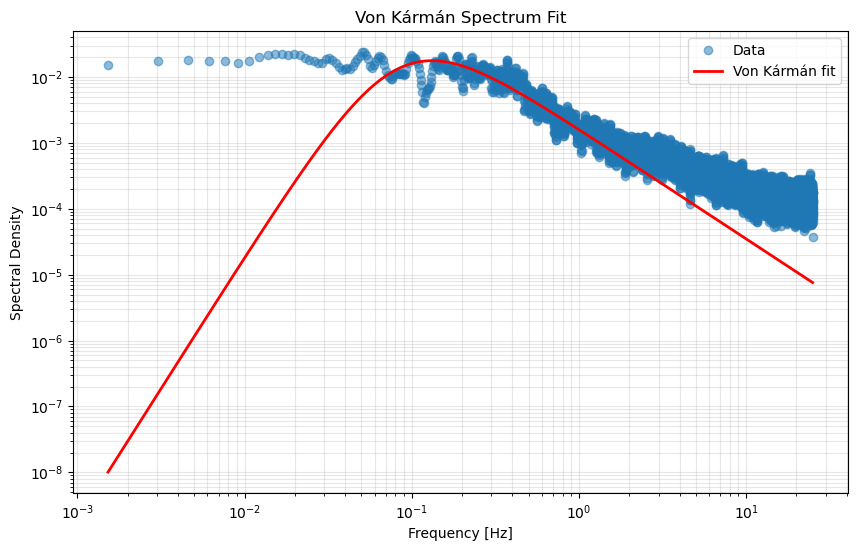

In [7]:
# Plot the fit
# Use only positive frequencies for fit line
f_min = df_ETIL[df_ETIL['frequency'] > 0]['frequency'].min()
f_max = df_ETIL['frequency'].max()
f_fit = np.logspace(np.log10(f_min), np.log10(f_max), 500)
E_fit = von_karman_full(f_fit, alpha_fit, epsilon_fit, L_fit)

plt.figure(figsize=(10, 6))
plt.loglog(df_ETIL['frequency'], df_ETIL['spectral density'], 'o', alpha=0.5, label='Data')
plt.loglog(f_fit, E_fit, 'r-', linewidth=2, label='Von Kármán fit')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Spectral Density')
plt.title('Von Kármán Spectrum Fit')
plt.legend()
plt.grid(True, which='both', alpha=0.3)
plt.show()

In [8]:
# Calculate goodness of fit
E_model = von_karman_full(df_ETIL['frequency'], alpha_fit, epsilon_fit, L_fit)
residuals = df_ETIL['spectral density'] - E_model
ss_res = np.sum(residuals**2)
ss_tot = np.sum((df_ETIL['spectral density'] - np.mean(df_ETIL['spectral density']))**2)
r_squared = 1 - (ss_res / ss_tot)

print(f"\nGoodness of fit:")
print(f"  R² = {r_squared:.6f}")


Goodness of fit:
  R² = 0.688461


## Extract Parameters for GenerateInflow.c (ETIL dataset)

In [14]:
# Extract parameters for ETIL dataset
Y_loc = 0.2794  # [m] Reference height
V_ref = 0.82  # [m/s] Reference velocity
L_ref = 0.2794   # [m] Reference length

print("=== Input Parameters (user-defined) ===")
print(f"Y_loc = {Y_loc:.4f} m")
print(f"V_ref = {V_ref:.4f} m/s")
print(f"L_ref = {L_ref:.4f} m")
print()

# From fitted spectrum (ETIL):
alpha_spectrum = alpha_fit
epsilon_spectrum = epsilon_fit
L_spectrum = L_fit

print("=== Fitted Spectrum Parameters (ETIL) ===")
print(f"α = {alpha_spectrum:.6f}")
print(f"ε = {epsilon_spectrum:.6e} m²/s³")
print(f"L = {L_spectrum:.6f} m")
print()

# Calculate GenerateInflow.c parameters:
D_coef = alpha_spectrum
ustar_dimensional = (epsilon_spectrum * Y_loc)**(1/3)
ustar = ustar_dimensional / V_ref
ustar4mean = ustar
L_coef = L_spectrum / Y_loc
Y_loc_nondim = Y_loc / L_ref

print("=== GenerateInflow.c Parameters (dimensional) ===")
print(f"D_coef = {D_coef:.6f}")
print(f"ustar = {ustar_dimensional:.6f} m/s")
print(f"L_coef = {L_coef:.6f}")
print(f"Y_loc = {Y_loc:.6f} m")
print()

=== Input Parameters (user-defined) ===
Y_loc = 0.2794 m
V_ref = 0.8200 m/s
L_ref = 0.2794 m

=== Fitted Spectrum Parameters (ETIL) ===
α = 2.885430
ε = 2.174186e-03 m²/s³
L = 1.530507 m

=== GenerateInflow.c Parameters (dimensional) ===
D_coef = 2.885430
ustar = 0.084692 m/s
L_coef = 5.477835
Y_loc = 0.279400 m

